In [23]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents.csv
/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv


In [2]:
!pip install torch==1.4.0
!pip install transformers==2.9.0
!pip install pytorch_lightning==0.7.5


PATH_TRAIN = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_train.csv"
PATH_TRAIN = "/kaggle/input/atis-airlinetravelinformationsystem/atis_intents_test.csv"

     |████████████████████████████████| 753.4 MB 4.8 kB/s  eta 0:00:01    |████▏                           | 97.1 MB 71.1 MB/s eta 0:00:10     |████▎                           | 99.8 MB 71.1 MB/s eta 0:00:10     |██████████▋                     | 249.6 MB 60.8 MB/s eta 0:00:09     |██████████████████▎             | 431.1 MB 54.7 MB/s eta 0:00:06     |█████████████████████████       | 587.6 MB 57.4 MB/s eta 0:00:03     |███████████████████████████████▉| 750.5 MB 58.8 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.7.0
    Uninstalling torch-1.7.0:
      Successfully uninstalled torch-1.7.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kornia 0.4.1 requires torch>=1.6.0, but you have torch 1.4.0 which is incompatible.
fastai 2.1.8 requires torch>=1.7.0, but you have torch 1.4.0 which is incompatible.
allennlp 1.2.2 requir

  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 1.0.8
    Uninstalling pytorch-lightning-1.0.8:
      Successfully uninstalled pytorch-lightning-1.0.8
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
df = pd.read_csv(PATH_TRAIN, header=None, names=['intent', 'dialog'])
display(df.head())
df['intent'].value_counts()
flag=0

,intent,dialog
0,atis_flight,i would like to find a flight from charlotte ...
1,atis_airfare,on april first i need a ticket from tacoma to...
2,atis_flight,on april first i need a flight going from pho...
3,atis_flight,i would like a flight traveling one way from ...
4,atis_flight,i would like a flight from orlando to salt la...


In [20]:
m = 0
for a in list(df['dialog']):
    m = max(m,len(a))
m

175

atis_flight_time intent has been dropped due to its frequency less than 9
atis_flight_time intent has been dropped due to its frequency less than 9
atis_quantity intent has been dropped due to its frequency less than 9
atis_aircraft intent has been dropped due to its frequency less than 9


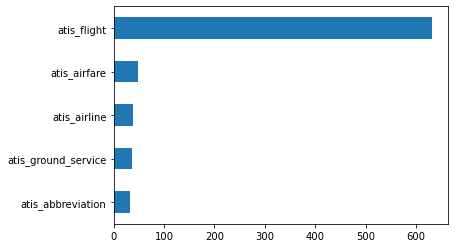

In [4]:
# drop rows with very very less number of intents (<=9)
drop_intents = ["atis_flight_time", "atis_flight_time", "atis_quantity", "atis_aircraft"]
for x in drop_intents:
    if flag==1:
        print("intents have already been dropped. Proceed ahead")
        break
    drop_dialog = df[df['intent']==x].index
    df = df.drop(drop_dialog)
    print(f"{x} intent has been dropped due to its frequency less than 9")
flag=1
df['intent'].value_counts().plot(kind='barh').invert_yaxis()

In [5]:
df['intent'].value_counts()

atis_flight            632
atis_airfare            48
atis_airline            38
atis_ground_service     36
atis_abbreviation       33
Name: intent, dtype: int64

In [6]:
import torch
from transformers import T5ForConditionalGeneration,T5Tokenizer

def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

model = T5ForConditionalGeneration.from_pretrained('ramsrigouthamg/t5_paraphraser')
tokenizer = T5Tokenizer.from_pretrained('t5-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)

# sentence = "What are the ingredients required to bake a perfect cake?"
# sentence = "What is the best possible approach to learn aeronautical engineering?"
# sentence = "Do apples taste better than oranges in general?"



device  cpu


Steps to be followed:
 
1. Paraphrase T5 mdoel defintion
2. Paraphrase Generation for each intent separately
3. Paraphrase same label allocation
4. Save that augmented data

In [15]:
intent_utter = {}
intents = "atis_flight atis_airfare atis_airline atis_ground_service atis_abbreviation".split()

for intent in intents:
    if intent not in intent_utter.keys():
        intent_utter[intent] = list(df[df['intent']==intent]['dialog'])
        print(f"Number of uttenrances of {intent} intent are {len(intent_utter[intent])}")
print(intent_utter.keys())

Number of Uttenrances of atis_flight intent are 632
Number of Uttenrances of atis_airfare intent are 48
Number of Uttenrances of atis_airline intent are 38
Number of Uttenrances of atis_ground_service intent are 36
Number of Uttenrances of atis_abbreviation intent are 33
dict_keys(['atis_flight', 'atis_airfare', 'atis_airline', 'atis_ground_service', 'atis_abbreviation'])


In [25]:
# data = ["I'm doing well. Thanks for asking. So you're here at the agency today to seek counseling services?", "Yes", "Absolutely. That's what I do", "You are amazing"]

for intent in intents[1:]:
    utterances = intent_utter[intent]
    paraphrases = []
    for sentence in tqdm(utterances): 
        text =  "paraphrase: " + sentence + " </s>"
        max_len = 200
        encoding = tokenizer.encode_plus(text,pad_to_max_length=True, return_tensors="pt")
        input_ids, attention_masks = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)

        # set top_k = 50 and set top_p = 0.95 and num_return_sequences = 3
        beam_outputs = model.generate(
            input_ids=input_ids, attention_mask=attention_masks,
            do_sample=True,
            max_length=max_len,
            top_k=120,
            top_p=0.98,
            early_stopping=True,
            num_return_sequences=10
        )

        final_outputs = []
        temp = 0
        for beam_output in beam_outputs:
            sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
            if sent.lower() != sentence.lower() and sent not in final_outputs:
                paraphrases.append(sent)
                temp+=1
                if temp>2: break
        
        
    intent_utter[intent]= intent_utter[intent]+paraphrases

100%|██████████| 33/33 [02:31<00:00,  4.61s/it]


In [27]:
for each in intent_utter.keys():
    print(len(intent_utter[each]))

632
192
152
144
132


In [43]:
new_df = df[df['intent']=='atis_flight']

for each in intents[1:]:
    temp_df = pd.DataFrame()
    temp_df['dialog'] = intent_utter[each]
    temp_df['intent'] = each
    new_df = pd.concat([new_df,temp_df])

In [49]:
new_df = new_df.sample(frac=1)
new_df.head()
new_df.to_csv('para_df.tsv', sep='\t', index=None)